# Molecular Dynamics Simulations

## Overview

### Questions

* How do I set up a rigid body with hoomd blue?

### Objectives

* Describe how to correctly add a rigid body to hoomd.
* Explain how filtering of the rigid body works in hoomd.
* Show how hoomd adds constituent particles to a rigid body.

## Boilerplate code

In [1]:
import itertools
import math

import gsd.hoomd
import hoomd
import numpy
import rowan

from hoomd.md import constrain

The `render_simulation` function in the next (hidden) cell will render the system state using **fresnel**.

<div class="alert alert-info">
    This is not intended as a full tutorial on <b>fresnel</b> - see the <a href="https://fresnel.readthedocs.io/">fresnel user documentation</a> if you would like to learn more.
</div>

In [2]:
import fresnel
import IPython

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

def render_simulation(radius_constituent,snapshot):
    '''
    Outputs sphere positions based on the trajectory of the simulation
    '''
    wh_sp = numpy.where((snapshot.particles.typeid == 1))
    pos_parts = snapshot.particles.position[wh_sp]
    L = snapshot.configuration.box[0]
    
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(scene,
                                       N=len(pos_parts),
                                       radius=radius_constituent)
    geometry.position[:] = pos_parts
    geometry.material = fresnel.material.Material(color=fresnel.color.linear(
        [252 / 255, 209 / 255, 1 / 255]),
                                                  roughness=0.5)
    geometry.outline_width = 0.04
    box = fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=.02)
    
    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1),
                            color=(0.8, 0.8, 0.8),
                            theta=math.pi),
        fresnel.light.Light(direction=(1, 1, 1),
                            color=(1.1, 1.1, 1.1),
                            theta=math.pi / 3)
    ]
    scene.camera = fresnel.camera.orthographic(position=(L * 2, L, L * 2),
                                               look_at=(0, 0, 0),
                                               up=(0, 1, 0),
                                               height=L * 1.4 + 1)
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

As in the previous tutorial we take our rigid body, diagonalize the moment of inertia and reorient the rigid body. 

In [3]:
const_sp_pos1 = numpy.array([.5,.5,0]) 
const_sp_pos2 = numpy.array([-.5,-.5,0]) 
body_pos = numpy.array([const_sp_pos1,const_sp_pos2])
mass = 10
radius = 1
I_ref = numpy.array([[2/5*mass*radius**2,0,0],[0,2/5*mass*radius**2,0],[0,0,2/5*mass*radius**2]])
I_1 = I_ref + mass*(numpy.dot(const_sp_pos1,const_sp_pos1)*numpy.identity(3) + numpy.outer(const_sp_pos1,const_sp_pos1))
I_2 = I_ref + mass*(numpy.dot(const_sp_pos2,const_sp_pos2)*numpy.identity(3) + numpy.outer(const_sp_pos2,const_sp_pos2))
I_tot = I_1 + I_2
I_prin, E_vec = numpy.linalg.eig(I_tot)
R = numpy.transpose(E_vec)

# Now we rotate the points to coincide with the diagonalized tensor using the rotation matrix
const_sp_pos1_new =numpy.dot(R,numpy.transpose(numpy.array([const_sp_pos1])))[:,0]
const_sp_pos2_new =numpy.dot(R,numpy.transpose(numpy.array([const_sp_pos2])))[:,0]

I_1_new = I_ref + mass*(numpy.dot(const_sp_pos1_new,const_sp_pos1_new)*numpy.identity(3) + numpy.outer(const_sp_pos1_new,const_sp_pos1_new))
I_2_new = I_ref + mass*(numpy.dot(const_sp_pos2_new,const_sp_pos2_new)*numpy.identity(3) + numpy.outer(const_sp_pos2_new,const_sp_pos2_new))

I_tot_new = I_1_new + I_2_new

# Redefine the moments of inertia and particle positions as the rotated ones
I_tot = I_tot_new
const_sp_pos1 = const_sp_pos1_new 
const_sp_pos2 = const_sp_pos2_new 

# Setting up a simulation

To initialize the simulation we need: 
* The positions of the center of mass of the rigid bodies
* The positions of the constituent particles of the rigid bodies
* The diagonalized moments of inertia of the rigid bodies

Technical Issues with Rigid Bodies: 
* We want the integrator for the rigid body to not integrate the constituent particles but rather integrate the sum of forces on the rigid body from the interaction between the constituent particles. 
* To do this, we must **filter** interactions so the integrator only integrates over **free** particles and **center** particles (particles representing the center of mass) but not the **constituent** particles that make up the rigid body.

Steps to Initializing the Simulation: 

* Rigid Body Initialization 

    * Initialize simulation from a snapshot containing only the positions and properties of the rigid bodies, not the constituent particles. 
    * Create a cell list the filters out the rigid bodies which are composed of constituent particles
    * Create a **filter** for the integrator that only integrates the rigid bodies 
    * Create a force field for the constituent particles
    * Create an integrator
    * Add a rigid body constraint and define the particles within the rigid body
    * Create particles in the rigid body in the simulation. 
    * Add rigid bodies to the integrator

* Final Setup
    * Give particles random momenta drawn correctly drawn from the Boltzmann distribution for the current temperature
    * Run Simulation at Desired Temperature

In [4]:
m = 2
N_particles = 2 * m**3
spacing = 10.
K = math.ceil(N_particles**(1 / 3))
L = K * spacing
x = numpy.linspace(-L / 2, L / 2, K, endpoint=False)
position = list(itertools.product(x, repeat=3))
position = numpy.array(position)
position[:,0] = position[:,0]
snapshot = gsd.hoomd.Snapshot()
snapshot.particles.N = N_particles
snapshot.particles.position = position[0:N_particles,:]
snapshot.particles.orientation = [(1,0,0,0)] * N_particles
snapshot.particles.typeid = [0] * N_particles
snapshot.configuration.box = [L, L, L, 0, 0, 0]
snapshot.particles.mass = [mass] * N_particles
snapshot.particles.types = ['rigid_body','constituent_sphere']
snapshot.particles.moment_inertia = [(I_prin[0],I_prin[1],I_prin[2])] * N_particles
snapshot.particles.angmom = [(1,1,1,1)] * N_particles
with gsd.hoomd.open(name='lattice_rigid.gsd', mode='wb') as f:
    f.append(snapshot)

As with other tutorials we are creating a device to do the simulation with.

In [5]:
cpu = hoomd.device.CPU()
sim = hoomd.Simulation(device=cpu, seed=1)
sim.create_state_from_gsd(filename='lattice_rigid.gsd')

We now create the force field the particles will interact. 

## Note:
We must choose to integrate our rotational degrees of freedom.

In [6]:
epsilon = 1
sigma = radius
integrator = hoomd.md.Integrator(dt=0.0001,integrate_rotational_dof=True)
cell = hoomd.md.nlist.Cell(exclusions = ['body'])
lj = hoomd.md.pair.LJ(nlist=cell)
lj.params[('rigid_body', 'rigid_body')] = dict(epsilon=0, sigma=sigma)
lj.params[('rigid_body', 'constituent_sphere')] = dict(epsilon=0, sigma=sigma)
lj.params[('constituent_sphere', 'constituent_sphere')] = dict(epsilon=epsilon, sigma=sigma)
lj.r_cut[('constituent_sphere', 'constituent_sphere')] = 2.5
lj.r_cut[('rigid_body', 'rigid_body')] = 2.5
lj.r_cut[('rigid_body', 'constituent_sphere')] = 2.5
integrator.forces.append(lj)

We now 'filter' our integration so just the rigid bodies are integrated over by choosing 'center' and 'free bodies.  

In [7]:
rigid_centers_and_free_filter = hoomd.filter.Rigid(("center", "free"))
nvt = hoomd.md.methods.NVT(kT = 10, tau = 1, filter = rigid_centers_and_free_filter)
integrator.methods.append(nvt)

We now must create a list of particles within the rigid body.

In [8]:
rigid = constrain.Rigid()

constituent_types = ['constituent_sphere','constituent_sphere']

rigid.body['rigid_body'] = {
    "constituent_types": constituent_types,
    "positions":[const_sp_pos1,const_sp_pos2],
    "orientations":[(1,0,0,0)] * len(constituent_types),
    "charges":[0.] * len(constituent_types),
    "diameters":[2 * sigma] * len(constituent_types)}

We now explicitly create the rigid bodies in the simulation and add a gsd logger.

In [9]:
rigid.create_bodies(sim.state)
integrator.rigid = rigid
sim.operations.integrator = integrator

# Gsd writer for simulations
logger = hoomd.logging.Logger(['state','constraint'])
gsd_oper = hoomd.write.GSD(trigger=hoomd.trigger.Periodic(100), filename='randomization.gsd',log=logger,mode='wb',dynamic=['momentum','property'])
sim.operations += gsd_oper

## Randomize the System

We now want to give the particles randomized thermal momenta sampled from Boltzman distribution at the temperature of the system. 

In [10]:
sim.state.thermalize_particle_momenta(filter=rigid_centers_and_free_filter, kT=1.5)

We now run the system for a desired number of timesteps and then render the last frame.

In [11]:
sim.run(100000)

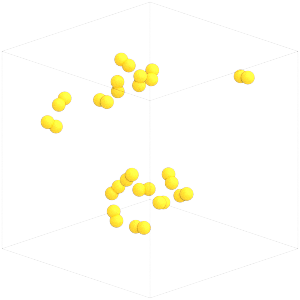

In [12]:
snapshot = gsd.hoomd.open('randomization.gsd')[-1]
render_simulation(radius,snapshot)